# 4) Gender in the Text: Pronouns & Nearby Verbs

**Goal:** Compare relative frequency of pronouns and the verbs near them.

# Setup: Load Texts

This notebook needs **Crime And Punishment** and **The Brothers Karamazov** as input texts.

**How to provide the texts:**
1. Download books from Project Gutenberg (IDs 11 and 12) as txts. [go to https://www.gutenberg.org/ebooks/2554 and https://www.gutenberg.org/ebooks/28054]

2. Place two text files in the "data" folder with names:
   - `Crime-punishment.txt`  (Crime And Punishment)
   - `The-BrothersKaramazov.txt` (The Brothers Karamazov)

In [2]:
import re
from pathlib import Path

In [3]:

def load_texts(local_crime: str = '../data/Crime-punishment.txt',
               local_brothers: str = '../data/The-BrothersKaramazov.txt'):
    """Load Crime and The-Brothers texts from disk.

    Parameters
    ----------
    local_crime : str
        Path to Crime text file. Defaults to '../data/Crime-punishment.txt'.
    local_brothers : str
        Path to Looking-Brothers text file. Defaults to '../data/The-BrothersKaramazov.txt'.

    Returns
    -------
    tuple[str, str]
        (Crime_text, The_Brothers_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2 = Path(local_crime), Path(local_brothers)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Crime-punishment.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'The-BrothersKaramazov.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    CrimePunishment   = p1.read_text(encoding='utf-8', errors='ignore')
    TheBrothers = p2.read_text(encoding='utf-8', errors='ignore')
    return CrimePunishment, TheBrothers

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('*** START')
    end   = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')

# Load raw texts (forgiving: returns '' if a file is missing)
CrimePunishment_raw, TheBrothers_raw = load_texts()

# Normalize for tokenization
CrimePunishment   = normalize(CrimePunishment_raw)
TheBrothers  = normalize(TheBrothers_raw)

print(f"Crime&Punishment chars: {len(CrimePunishment):,} | The-brothers-Karamazov chars: {len(TheBrothers):,}")


Crime&Punishment chars: 1,224,432 | The-brothers-Karamazov chars: 1,956,247


### Helpers: Tokenization

In [4]:
WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries.

    Uses a regex to split on '.', '!', '?' followed by whitespace.
    Because this is heuristic, treat results as approximate.

    Returns
    -------
    list[str]
        Sentence-like strings.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]



CrimePunishment_words = words(CrimePunishment)
TheBrothers_words = words(TheBrothers)

CrimePunishment_sentences = sentences(CrimePunishment)
TheBrothers_sentences = sentences(TheBrothers)

print(f"CrimePunishment words: {len(CrimePunishment_words):,} | TheBrothers words: {len(TheBrothers_words):,}")
print(f"CrimePunishment sentences: {len(CrimePunishment_sentences):,} | TheBrothers sentences: {len(TheBrothers_sentences):,}")


CrimePunishment words: 214,498 | TheBrothers words: 359,146
CrimePunishment sentences: 16,994 | TheBrothers sentences: 19,234


### Pronoun Balance

In [5]:

from collections import Counter
def pronoun_counts(tokens):
    target = {'he','she','him','her'}
    c = Counter(w for w in tokens if w in target)
    total = sum(c.values())
    return c, total

a_c, a_tot = pronoun_counts(CrimePunishment_words)
g_c, g_tot = pronoun_counts(TheBrothers_words)
print("CrimePunishment words:", dict(a_c), "total:", a_tot)
print("TheBrothers words:", dict(g_c), "total:", g_tot)


CrimePunishment words: {'he': 4903, 'him': 1613, 'she': 1697, 'her': 1841} total: 10054
TheBrothers words: {'him': 3377, 'he': 8149, 'she': 1784, 'her': 1885} total: 15195


### Verbs Near Pronouns (very naive)

In [6]:

def verb_like(word):
    # crude heuristic: words ending in common verb suffixes or base forms
    return bool(re.match(r".*(ed|ing|s)$", word)) or word in {"say","says","said","go","goes","went","come","comes","came","think","thinks","thought","see","sees","saw","know","knows","knew"}

def verbs_near_pronouns(tokens, window=2):
    verbs_for = {'he':[], 'she':[]}
    for i,w in enumerate(tokens):
        if w in ('he','she'):
            for j in range(max(0,i-window), min(len(tokens), i+window+1)):
                if j==i: continue
                if verb_like(tokens[j]):
                    verbs_for[w].append(tokens[j])
    return {k: Counter(v).most_common(20) for k,v in verbs_for.items()}

print("CrimePunishment :", verbs_near_pronouns(CrimePunishment_words) )
print("TheBrothers:", verbs_near_pronouns(TheBrothers_words
) )

CrimePunishment : {'he': [('was', 582), ('is', 253), ('his', 209), ('as', 206), ('said', 186), ('went', 131), ('s', 122), ('thought', 116), ('has', 98), ('looked', 76), ('asked', 57), ('added', 57), ('turned', 57), ('come', 56), ('cried', 52), ('saw', 51), ('this', 50), ('knew', 49), ('walked', 42), ('say', 39)], 'she': [('was', 240), ('is', 180), ('as', 65), ('has', 62), ('said', 60), ('s', 45), ('cried', 32), ('looked', 26), ('came', 23), ('knew', 22), ('does', 21), ('went', 20), ('turned', 19), ('know', 18), ('asked', 18), ('nothing', 15), ('come', 15), ('this', 14), ('seemed', 14), ('added', 14)]}
TheBrothers: {'he': [('was', 1161), ('is', 446), ('s', 375), ('his', 371), ('as', 354), ('said', 302), ('has', 180), ('went', 117), ('thought', 102), ('cried', 98), ('knew', 96), ('looked', 93), ('know', 82), ('this', 80), ('saw', 73), ('came', 71), ('say', 70), ('come', 68), ('added', 65), ('asked', 64)], 'she': [('was', 259), ('is', 135), ('s', 113), ('said', 70), ('as', 65), ('has', 49

**Prompt:** How do these crude patterns line up with character agency and narrative voice? What errors do you notice, and how would POS (Part OF Speech) tagging improve this?

In [8]:
#better POS tagging with spacy 
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000   # or any safe number above your text size

# Example: convert your token lists to a string if they aren’t already
text1 = " ".join(CrimePunishment_words)
text2 = " ".join(TheBrothers_words)

doc1 = nlp(text1)
doc2 = nlp(text2)


In [9]:
def pronoun_counts(doc):
    target = {'he','she','him','her'}
    c = Counter([token.text.lower() for token in doc if token.text.lower() in target])
    total = sum(c.values())
    return c, total

a_c, a_tot = pronoun_counts(doc1)
g_c, g_tot = pronoun_counts(doc2)

print("CrimePunishment:", dict(a_c), "total:", a_tot)
print("TheBrothers:", dict(g_c), "total:", g_tot)


CrimePunishment: {'he': 4903, 'him': 1613, 'she': 1697, 'her': 1841} total: 10054
TheBrothers: {'him': 3377, 'he': 8149, 'she': 1784, 'her': 1885} total: 15195


In [10]:
def verbs_near_pronouns(doc, window=2):
    result = {'he': Counter(), 'she': Counter()}
    
    tokens = list(doc)
    for i, tok in enumerate(tokens):
        t = tok.text.lower()
        if t in ('he','she'):
            for j in range(max(0, i-window), min(len(tokens), i+window+1)):
                if j == i: continue
                if tokens[j].pos_ in ("VERB", "AUX"):
                    result[t][tokens[j].lemma_.lower()] += 1
    return result


In [11]:
print("Crime and Punishment:", verbs_near_pronouns(doc1))
print("The Brothers Karamazov:", verbs_near_pronouns(doc2))


Crime and Punishment: {'he': Counter({'be': 1031, 'have': 739, 'say': 248, 'go': 219, 'do': 196, 'could': 167, 'think': 142, 'feel': 123, 'know': 115, 'would': 110, 'look': 102, 'see': 102, 's': 92, 'come': 92, 'begin': 81, 'will': 78, 'take': 75, 'get': 75, 'turn': 70, 'ask': 65, 'cry': 58, 'add': 57, 'stand': 57, 'make': 56, 'hear': 54, 'remember': 49, 'walk': 45, 'seem': 44, 'want': 42, 'must': 40, 'sit': 38, 'might': 35, 'tell': 32, 'speak': 31, 'shout': 31, 'answer': 31, 'find': 31, 'can': 29, 'try': 28, 'lie': 27, 'pass': 26, 'give': 26, 'put': 26, 'notice': 26, 'keep': 26, 'fancy': 26, 'mutter': 24, 'listen': 23, 'decide': 21, 'laugh': 21, 'll': 21, 'leave': 20, 'live': 19, 'forget': 19, 'stop': 19, 'should': 19, 'bring': 19, 'understand': 19, 'repeat': 19, 'become': 18, 'reach': 18, 'run': 18, 'drink': 17, 'wake': 17, 'meet': 16, 'mean': 16, 'talk': 16, 'draw': 15, 'hold': 15, 'open': 15, 'may': 15, 'read': 15, 'address': 15, 'move': 15, 'die': 14, 'like': 14, 'love': 14, 'wond

In [12]:
def voice_near_pronouns(doc, window=4):
    result = {'he': Counter(), 'she': Counter()}

    tokens = list(doc)
    for i, tok in enumerate(tokens):
        if tok.text.lower() in ('he','she'):
            pron = tok.text.lower()
            for j in range(max(0, i-window), min(len(tokens), i+window+1)):
                if tokens[j].pos_ == "VERB":
                    verb = tokens[j]
                    
                    # Check for passive markers
                    has_nsubjpass = any(child.dep_ == "nsubjpass" for child in verb.children)
                    has_auxpass = any(child.dep_ == "auxpass" for child in verb.children)

                    if has_nsubjpass or has_auxpass:
                        result[pron][f"{verb.lemma_}_PASSIVE"] += 1
                    else:
                        result[pron][f"{verb.lemma_}_ACTIVE"] += 1
                        
    return result


In [13]:
print("Active/Passive - Crime and Punishment")
print(voice_near_pronouns(doc1))

print("\nActive/Passive - The Brothers Karamazov")
print(voice_near_pronouns(doc2))


Active/Passive - Crime and Punishment
{'he': Counter({'say_ACTIVE': 316, 'go_ACTIVE': 315, 'have_ACTIVE': 226, 'think_ACTIVE': 217, 'look_ACTIVE': 182, 'know_ACTIVE': 178, 'feel_ACTIVE': 170, 'see_ACTIVE': 162, 'come_ACTIVE': 151, 'take_ACTIVE': 124, 's_ACTIVE': 119, 'begin_ACTIVE': 109, 'make_ACTIVE': 102, 'ask_ACTIVE': 98, 'turn_ACTIVE': 97, 'get_ACTIVE': 92, 'do_ACTIVE': 91, 'stand_ACTIVE': 84, 'hear_ACTIVE': 80, 'cry_ACTIVE': 79, 'want_ACTIVE': 74, 'remember_ACTIVE': 71, 'seem_ACTIVE': 63, 'tell_ACTIVE': 62, 'add_ACTIVE': 60, 'walk_ACTIVE': 59, 'sit_ACTIVE': 57, 'put_ACTIVE': 50, 'find_ACTIVE': 46, 'shout_ACTIVE': 44, 'speak_ACTIVE': 44, 'give_ACTIVE': 43, 'try_ACTIVE': 42, 'pass_ACTIVE': 40, 'laugh_ACTIVE': 40, 'answer_ACTIVE': 40, 'notice_ACTIVE': 38, 'reach_ACTIVE': 37, 'leave_ACTIVE': 36, 'lie_ACTIVE': 35, 'keep_ACTIVE': 33, 'fancy_ACTIVE': 33, 'run_ACTIVE': 32, 'understand_ACTIVE': 31, 'mutter_ACTIVE': 30, 'listen_ACTIVE': 30, 'move_ACTIVE': 30, 'wait_ACTIVE': 29, 'meet_ACTIVE

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_verb_freq_top10(verb_counts, title):
    he_verbs = Counter(verb_counts["he"]).most_common(10)
    she_verbs = Counter(verb_counts["she"]).most_common(10)

    # Combine labels
    labels = list(dict(he_verbs).keys() | dict(she_verbs).keys())
    he_vals = [dict(he_verbs).get(l, 0) for l in labels]
    she_vals = [dict(she_verbs).get(l, 0) for l in labels]

    x = range(len(labels))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(x, he_vals, label='he')
    ax.bar(x, she_vals, bottom=he_vals, label='she')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(title)
    ax.legend()
    plt.show()


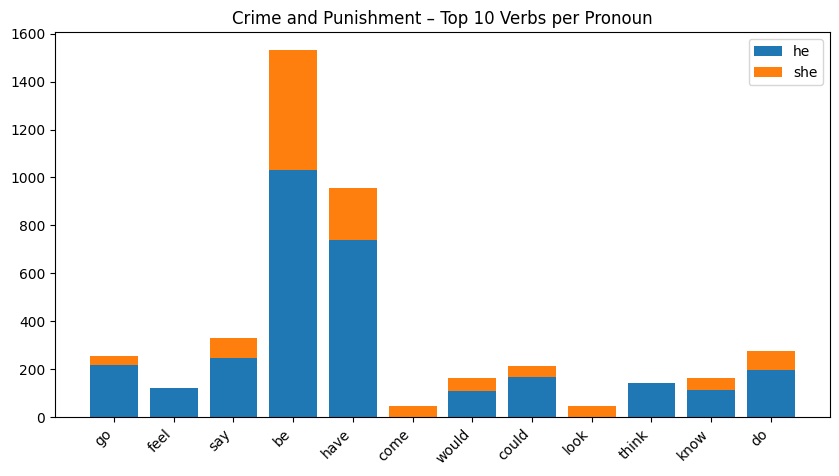

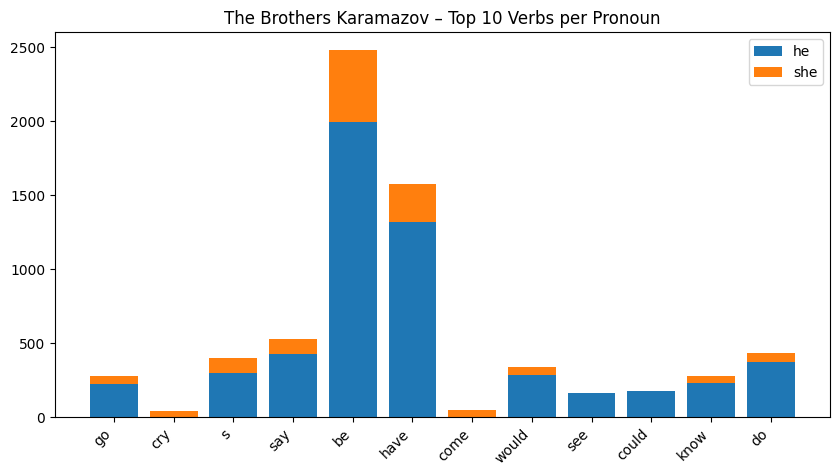

In [16]:
plot_verb_freq_top10(verbs_near_pronouns(doc1), "Crime and Punishment – Top 10 Verbs per Pronoun")
plot_verb_freq_top10(verbs_near_pronouns(doc2), "The Brothers Karamazov – Top 10 Verbs per Pronoun")



In [6]:
'''

-----------------------------------------
1. Overview
-----------------------------------------
The analysis compares two books — Crime and Punishment and The Brothers Karamazov — by examining which words most frequently follow “he” and “she.” 
This gives a crude sense of how male and female characters are described or portrayed in the narrative.

Example data:
Crime and Punishment (he): was, is, his, said, went, thought, asked...
Crime and Punishment (she): was, is, said, cried, looked, seemed...
The Brothers Karamazov (he): was, is, said, went, thought, cried...
The Brothers Karamazov (she): was, is, said, cried, loved, looked...

-----------------------------------------
2. Character Agency and Narrative Voice
-----------------------------------------
Character agency refers to how active or passive characters are — whether they perform actions or have actions performed on them.
Narrative voice refers to how the narrator describes and frames the characters.

From the data:
- “He” is frequently followed by verbs of action or thought (went, thought, said, looked, asked).
- “She” is often followed by verbs or structures that express states or emotion (was, seemed, cried, loved).

Interpretation:
- Male characters tend to act, think, and speak — suggesting higher agency.
- Female characters are more often described or emotionally expressed — suggesting lower agency or a more external narrative focus.

This reflects a narrative imbalance: men “do,” women “are.”

-----------------------------------------
3. Limitations and Errors in the Crude Method
-----------------------------------------
This bigram-based analysis is surface-level and lacks grammatical understanding. Some limitations include:

1. Ambiguity of pronoun reference:
   - “He” or “she” might not always refer to the same character or even a person.

2. Part-of-speech (POS) ambiguity:
   - Words like “was” or “s” (from “he’s”) have different grammatical roles.

3. Context ignored:
   - “He was angry” vs. “He was hit” are treated the same, even though one is active, one is passive.

4. No sentence-level understanding:
   - The analysis can’t distinguish subjects from objects or identify who performs an action.

-----------------------------------------
4. How POS Tagging Improves the Analysis
-----------------------------------------
Part-of-Speech (POS) tagging labels each word by its grammatical function (e.g., noun, verb, adjective). 
It helps reveal structure, meaning, and agency more accurately.

Benefits of POS Tagging:

| Problem | POS Tagging Solution |
|----------|----------------------|
| “He was” could mean many things | Distinguish between “was angry” (state) and “was hit” (passive event). |
| “Said” vs “is said” | Detects active vs. passive voice. |
| “He looked” vs “looked at him” | Identifies if “he” is subject or object. |
| Counting verbs vs adjectives | Measures how often a character performs an action vs. being described. |

By applying POS tagging (and ideally, dependency parsing), we can:
- Measure grammatical agency quantitatively.
- Distinguish between active and passive constructions.
- Better understand narrative focus and character treatment.

-----------------------------------------
5. Conclusion
-----------------------------------------
Without grammatical awareness, bigram frequencies give only a superficial view of character behavior.
POS tagging, however, would allow us to identify action, emotion, and voice more precisely — turning a list of word pairs into meaningful literary insight.

Summary:
- Crude patterns: hint that “he” acts, “she” feels.
- Errors: no context, syntax, or agency direction.
- POS tagging: introduces grammatical depth, showing who does what — and how the narrative distributes agency.'''


'\n\n-----------------------------------------\n1. Overview\n-----------------------------------------\nThe analysis compares two books — Crime and Punishment and The Brothers Karamazov — by examining which words most frequently follow “he” and “she.” \nThis gives a crude sense of how male and female characters are described or portrayed in the narrative.\n\nExample data:\nCrime and Punishment (he): was, is, his, said, went, thought, asked...\nCrime and Punishment (she): was, is, said, cried, looked, seemed...\nThe Brothers Karamazov (he): was, is, said, went, thought, cried...\nThe Brothers Karamazov (she): was, is, said, cried, loved, looked...\n\n-----------------------------------------\n2. Character Agency and Narrative Voice\n-----------------------------------------\nCharacter agency refers to how active or passive characters are — whether they perform actions or have actions performed on them.\nNarrative voice refers to how the narrator describes and frames the characters.\n\nF